<div id="toc"></div>

# Forward modeling of the emission spectrum using VALD3

Tako Ishikawa, Hajime Kawahara  
created: : 2021/07/20,　　last update: 2024/06/14  

<!-- 
written with reference to :  
"exojax/examples/tutorial/Forward\ modeling.ipynb"  
"ghR/exojax_0/examples/testlines/line_strength_CO.py"  

cd ~/work

-->

This example provides how to use VALD3 for forward modeling of the emission spectrum. Currenty, we use exojax.spec.moldb as API for VALD3 because we have not implemented the VALD3 API in radis.api yet. 
Someday, we (or someone who is reading this document.) would include the VALD3 API in radis.api! 

In [2]:
from exojax.utils.grids import wavenumber_grid
from exojax.atm.atmprof import pressure_layer_logspace
from exojax.database import moldb , molinfo, contdb
from exojax.database import atomll 
from exojax.database.hitran  import line_strength
from exojax.database.hitran import doppler_sigma
import matplotlib.pyplot as plt
import jax.numpy as jnp
from jax import vmap, jit
import numpy as np
import os

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


## Wavenumber

In [3]:
#We set a wavenumber grid using wavenumber_grid.
nu_grid,wav,res = wavenumber_grid(10380, 10430, 4500, xsmode="lpf", unit="AA", wavelength_order="ascending") 

xsmode =  lpf
xsmode assumes ESLOG in wavenumber space: mode=lpf
The wavenumber grid should be in ascending order.
The users can specify the order of the wavelength grid by themselves.
Your wavelength grid is in ***  ascending  *** order


/home/tako/ghR/exojax/src/exojax/utils.grids.py:62: UserWarning: Both input wavelength and output wavenumber are in ascending order.
  warnings.warn(
/home/tako/ghR/exojax/src/exojax/utils.grids.py:62: UserWarning: Both input wavelength and output wavenumber are in ascending order.
  warnings.warn(


## T-P profile 

rtsolver:  ibased
Intensity-based n-stream solver, isothermal layer (e.g. NEMESIS, pRT like)


/home/tako/ghR/exojax/src/exojax/spec/dtau_mmwl.py:14: FutureWarning: dtau_mmwl might be removed in future.
  warnings.warn("dtau_mmwl might be removed in future.", FutureWarning)


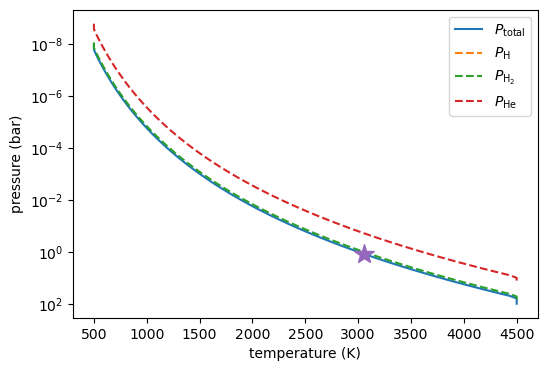

In [4]:
# Assume ATMOSPHERE                                                                     
from exojax.rt.atmrt import ArtEmisPure

nlayer=100
T0 = 3000. #10000. #3000. #1295.0 #K
alpha = 0.1
Tlow = 500.0
Thigh = 4500.0
art = ArtEmisPure(nu_grid=nu_grid, pressure_top=1.e-8, pressure_btm=1.e2, nlayer=nlayer)
art.change_temperature_range(Tlow, Thigh)
Tarr = art.powerlaw_temperature(T0, alpha)
Parr = art.pressure
dParr = art.dParr

H_He_HH_VMR = [0.0, 0.16, 0.84]  # typical quasi-"solar-fraction"
PH = Parr * H_He_HH_VMR[0]
PHe = Parr * H_He_HH_VMR[1]
PHH = Parr * H_He_HH_VMR[2]

fig = plt.figure(figsize=(6, 4))
plt.plot(Tarr, Parr, label="$P_\mathrm{total}$")
plt.plot(Tarr, PH, "--", label="$P_\mathrm{H}$")
plt.plot(Tarr, PHH, "--", label="$P_\mathrm{H_2}$")
plt.plot(Tarr, PHe, "--", label="$P_\mathrm{He}$")
plt.plot(Tarr[80], Parr[80], marker="*", markersize=15)
plt.yscale("log")
plt.xlabel("temperature (K)")
plt.ylabel("pressure (bar)")
plt.gca().invert_yaxis()
plt.legend()
plt.show()

## Load a database of atomic lines from VALD3

In [5]:
#Loading a database of a few atomic lines from VALD3  #BU: CO and CIA (H2-H2)... 
"""
    path_valdlines:  fullpath to the input line list obtained from VALD3 (http://vald.astro.uu.se/):
            VALD data access is free but requires registration through the Contact form (http://vald.astro.uu.se/~vald/php/vald.php?docpage=contact.html). 
            After the registration, you can login and select one of the following modes depending on your purpose: "Extract All", "Extract Stellar", or "Extract Element".
        For a example in this notebook, the request form of "Extract All" mode was filled as:
          Extract All
            Starting wavelength :    10380
            Ending wavelength :    10430
            Extraction format :    Long format
            Retrieve data via :    FTP
            (Hyperfine structure:    N/A)
            (Require lines to have a known value of :    N/A)
            Linelist configuration :    Default
            Unit selection:    Energy unit: eV - Medium: vacuum - Wavelength unit: angstrom - VdW syntax: default
        Please assign the fullpath of the output file sent by VALD ([user_name_at_VALD].[request_number_at_VALD].gz;  "vald2600.gz" in the code below) to the variable "path_valdlines".
        Note that the number of spectral lines that can be extracted in a single request is limited to 1000 in VALD (https://www.astro.uu.se/valdwiki/Restrictions%20on%20extraction%20size).
"""

path_valdlines = '.database/HiroyukiIshikawa.4214450.gz'

import urllib.request
from exojax.utils.url import url_developer_data
if not os.path.isdir(path_valdlines.split('/')[0]):
    print("Directory '" + path_valdlines.split('/')[0] + "' NOT found! This causes below.")
if not os.path.isfile(path_valdlines):
    try:
        url = url_developer_data() + path_valdlines.split('/')[-1]
        urllib.request.urlretrieve(url, path_valdlines)
    except:
        print('could not download ', url)
        
adbFe = moldb.AdbVald(path_valdlines, nu_grid)


Reading VALD file


## Relative partition function

In [6]:
#Computing the relative partition function,

qt_284 = vmap(adbFe.QT_interp_284)(Tarr)
qt = qt_284[:, adbFe.QTmask]
qr = qt / adbFe.QTref_284[adbFe.QTmask]

## Pressure and Natural broadenings (Lorentzian width)  


In [7]:
# volume mixing ratio (VMR) for e-
vmre = 10**-7 # assume an arbitrary uniform value here

from exojax.atm.idealgas import number_density
narr = number_density(Parr, Tarr)
number_density_e = vmre * narr

In [8]:
gammaLMP = jit(vmap(atomll.gamma_vald3,(0,0,0,0,None,None,None,None,None,None,None,None,None,None,None,0)))\
        (Tarr, PH, PHH, PHe, adbFe.ielem, adbFe.iion, \
                adbFe.dev_nu_lines, adbFe.elower, adbFe.eupper, adbFe.atomicmass, adbFe.ionE, \
                adbFe.gamRad, adbFe.gamSta, adbFe.vdWdamp, 1.0, number_density_e)  

## Doppler broadening

In [9]:
sigmaDM=jit(vmap(doppler_sigma,(None,0,None)))\
    (adbFe.nu_lines, Tarr, adbFe.atomicmass)

## Line strength

In [10]:
SijM=jit(vmap(line_strength,(0,None,None,None,0,None)))\
    (Tarr, adbFe.logsij0, adbFe.nu_lines, adbFe.elower, qr, adbFe.Tref)

## nu matrix

In [11]:
from exojax.opacity.initspec import init_lpf
numatrix=init_lpf(adbFe.nu_lines,nu_grid)

## Compute dtau for each atomic species (or ion) in a SEPARATE array

Separate species

In [12]:
def get_unique_list(seq):
    seen = []
    return [x for x in seq if x not in seen and not seen.append(x)]

uspecies = get_unique_list(jnp.vstack([adbFe.ielem, adbFe.iion]).T.tolist())

Set the stellar/planetary parameters

In [13]:
#Parameters of Objects
Rp = 0.36*10 #R_sun*10    #Rp=0.88 #[R_jup]
Mp = 0.37*1e3 #M_sun*1e3    #Mp=33.2 #[M_jup]
g = 2478.57730044555*Mp/Rp**2
print('logg: '+str(np.log10(g))) #check

logg: 4.849799190511717


Calculate delta tau

In [14]:
#For now, ASSUME all atoms exist as neutral atoms.
#In fact, we can't ignore the effect of molecular formation e.g. TiO (」゜□゜)」

from exojax.opacity.lpf import xsmatrix
from exojax.rt.layeropacity import layer_optical_depth
from exojax.database.atomllapi import load_atomicdata

ipccd = load_atomicdata()
ieleml = jnp.array(ipccd['ielem'])
Narr = jnp.array(10**(12 + ipccd['solarA']))  #number density
massarr = jnp.array(ipccd['mass'])  #mass of each neutral atom
Nmassarr = Narr * massarr  #mass of each neutral species

dtaual = np.zeros([len(uspecies), len(Tarr), len(nu_grid)])
maskl = np.zeros(len(uspecies)).tolist()

for i, sp in enumerate(uspecies):
    maskl[i] = (adbFe.ielem==sp[0])\
                    * (adbFe.iion==sp[1])

    #Currently not dealing with ionized species yet... (#tako %\\\\20210814)
    if sp[1] > 1:
        continue

    #Providing numatrix, thermal broadening, gamma, and line strength, we can compute cross section.
    xsm = xsmatrix(numatrix[maskl[i]], sigmaDM.T[maskl[i]].T,
                   gammaLMP.T[maskl[i]].T, SijM.T[maskl[i]].T)
    #Computing delta tau for atomic absorption
    MMR_X_I = Nmassarr[jnp.where(ieleml == sp[0])[0][0]] / jnp.sum(Nmassarr)
    mass_X_I = massarr[jnp.where(ieleml == sp[0])[0][
        0]]  #MMR and mass of neutral atom X (if all elemental species are neutral)
    dtaual[i] = layer_optical_depth(dParr, xsm, MMR_X_I * np.ones_like(Tarr), mass_X_I, g)


compute delta tau for CIA

In [15]:
cdbH2H2=contdb.CdbCIA('.database/H2-H2_2011.cia', nu_grid)

from exojax.rt.layeropacity import layer_optical_depth_CIA
mmw=2.33 #mean molecular weight
mmrH2=0.74
molmassH2=molinfo.molmass("H2")
vmrH2=(mmrH2*mmw/molmassH2) #VMR
dtaucH2H2=layer_optical_depth_CIA(nu_grid,Tarr,Parr,dParr,vmrH2,vmrH2,\
            mmw,g,cdbH2H2.nucia,cdbH2H2.tcia,cdbH2H2.logac)

H2-H2


## Total delta tau

In [16]:
dtau = np.sum(dtaual, axis=0) + dtaucH2H2

## Plot contribution function

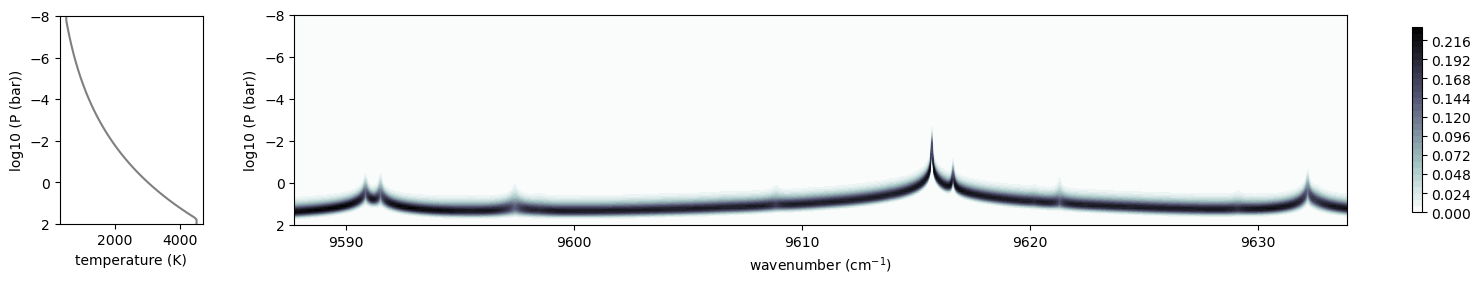

In [17]:
from exojax.plot.atmplot import plotcf
plotcf(nu_grid, dtau, Tarr, Parr, dParr)
plt.show()

## Radiative transfer

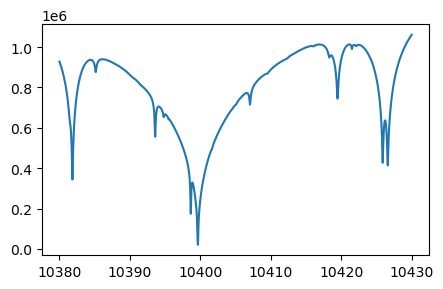

In [18]:
F0 = art.run(dtau, Tarr)

fig=plt.figure(figsize=(5, 3))
plt.plot(wav[::-1], F0)
plt.show()

In [19]:
#Check line species
print(np.unique(adbFe.ielem))

[12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 32 38 39 59 60 64
 65 66 70 80 90]


## Rotational & instrumental broadening

In [20]:
from exojax.postproc.response import ipgauss_sampling
from exojax.postproc.spin_rotation import convolve_rigid_rotation
from exojax.utils.constants import c #[km/s]
import jax.numpy as jnp

wavd = jnp.linspace(10380, 10430,500) #observational wavelength grid
nu_grid_d = 1.e8/wavd[::-1]

RV = 10.0 #RV km/s
vsini = 20.0 #Vsini km/s
vsini_max = 100.0
u1 = 0.0 #limb darkening u1
u2 = 0.0 #limb darkening u2

R = 100000.
beta = c/(2.0*np.sqrt(2.0*np.log(2.0))*R) #IP sigma need check 

from exojax.utils.grids import velocity_grid
vr_array = velocity_grid(res, vsini_max)

Frot = convolve_rigid_rotation(F0, vr_array, vsini, u1, u2)
F = ipgauss_sampling(nu_grid_d, nu_grid, Frot, beta, RV, varr_kernel=vr_array)

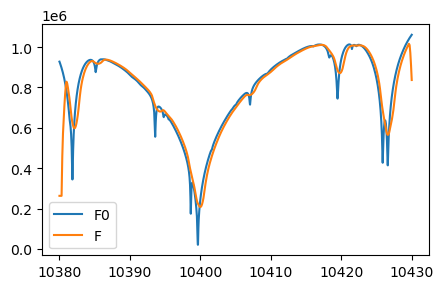

In [21]:
fig=plt.figure(figsize=(5, 3))
plt.plot(wav[::-1],F0, label='F0')
plt.plot(wavd[::-1],F, label='F')
plt.legend()
plt.show()